In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import math

In [2]:
whole_train = dd.read_csv('dataset/train.csv', parse_dates=['srch_ci', 'srch_co'])
train = whole_train.get_partition(0).head(10000)

In [3]:
train['nights'] = train['srch_co'] - train['srch_ci']
train['nights'] = train['nights'] / np.timedelta64(1, 'D')

for num in range(len(train['nights'])):
    if math.isnan(train['nights'].ix[num]) or train['nights'].ix[num]<0:
        num1 = num - 1
        num2 = num + 1
        if train.ix[num]['user_id'] == train.ix[num]['user_id'] and math.isnan(train['nights'].ix[num1]) == False:
            train['nights'].ix[num] = train.ix[num1]['nights']
        elif train.ix[num]['user_id'] == train.ix[num]['user_id'] and math.isnan(train['nights'].ix[num2]) == False:
            train['nights'].ix[num] = train.ix[num2]['nights']
        else:
            break

c:\python27\lib\site-packages\pandas\core\indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
del train['srch_ci']
del train['srch_co']
del train['date_time']

In [5]:
del train['site_name']
del train['user_id']
del train['orig_destination_distance']
# del train['user_location_city']
# del train['user_location_region']
# del train['user_location_country']
# del train['posa_continent']

# del train['is_package']
# del train['is_mobile']
# del train['channel']

# del train['srch_adults_cnt']
# del train['srch_children_cnt']
# del train['srch_rm_cnt']

# del train['srch_destination_id']
# del train['srch_destination_type_id']
# del train['is_booking']
# del train['cnt']

# del train['hotel_continent']
# del train['hotel_country']
# del train['hotel_market']
# del train['nights']

In [6]:
x = train.drop('hotel_cluster', axis=1)
y = train['hotel_cluster']

In [17]:
print x.columns
print len(x.columns)

Index([u'posa_continent', u'user_location_country', u'user_location_region',
       u'user_location_city', u'is_mobile', u'is_package', u'channel',
       u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt',
       u'srch_destination_id', u'srch_destination_type_id', u'is_booking',
       u'cnt', u'hotel_continent', u'hotel_country', u'hotel_market',
       u'nights'],
      dtype='object')
18


In [23]:
x.columns[9], x.columns[4], x.columns[0], x.columns[5]

('srch_rm_cnt', 'is_mobile', 'posa_continent', 'is_package')

feature ranking:
1. feature 13 (0.152734275854)
2. feature 16 (0.11365034211)
3. feature 10 (0.110828570645)
4. feature 3 (0.0942675926922)
5. feature 17 (0.0931406983621)
6. feature 2 (0.0741986000355)
7. feature 6 (0.063355967503)
8. feature 7 (0.047362370705)
9. feature 15 (0.0439833966729)
10. feature 11 (0.0392254306781)
11. feature 8 (0.0311360807798)
12. feature 1 (0.0287064750128)
13. feature 12 (0.0274025682738)
14. feature 14 (0.0272793063565)
15. feature 9 (0.0143315606569)
16. feature 4 (0.0134264366504)
17. feature 0 (0.0130316836859)
18. feature 5 (0.0119386433262)


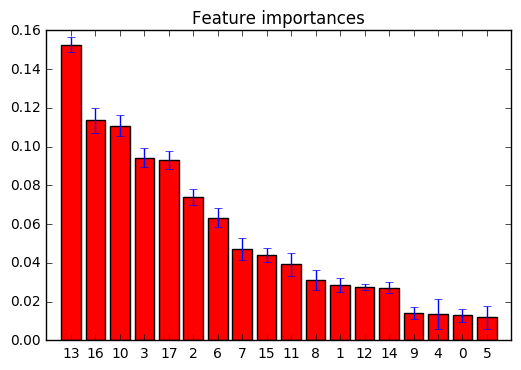

In [16]:
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

forest = ExtraTreesClassifier(n_estimators=18, random_state=0)
forest.fit(x, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

print 'feature ranking:'
for f in range(x.shape[1]):
    print '{}. feature {} ({})'.format(f+1, indices[f], importances[indices[f]])


plt.title('Feature importances')
plt.bar(range(x.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [27]:
x.columns[8]

'srch_children_cnt'

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

model1 = DecisionTreeClassifier().fit(x,y)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(x,y)

result1 = model1.predict(x)
result2 = model2.predict(x)

In [30]:
from sklearn.metrics import classification_report, accuracy_score

In [35]:
print classification_report(y, result1)

             precision    recall  f1-score   support

          0       0.49      0.91      0.64        98
          1       0.66      0.95      0.78       112
          2       0.52      0.92      0.67        78
          3       0.56      0.94      0.71        51
          4       0.62      0.79      0.70        77
          5       0.52      0.77      0.62       120
          6       0.67      0.78      0.72       118
          7       0.58      0.91      0.71        86
          8       0.52      0.79      0.63       137
          9       0.51      0.81      0.63        94
         10       0.51      0.84      0.64       103
         11       0.59      0.76      0.67        68
         12       0.68      0.88      0.77       138
         13       0.61      0.82      0.70        90
         14       0.61      0.71      0.66        84
         15       0.69      0.78      0.73        87
         16       0.69      0.76      0.72       144
         17       0.56      0.68      0.61   

In [36]:
print accuracy_score(y, result1)

0.6957


In [33]:
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier

model_1 = DecisionTreeClassifier().fit(x,y)
model_2 = BaggingClassifier().fit(x,y)
model_3 = SVC(probability=True).fit(x,y)
model_4 = VotingClassifier(estimators=[('dt', model_1), ('Bg', model_2), ('svc', model_3)],
                           voting='soft', weights=[3,1,0]).fit(x,y)



In [8]:
from sklearn.metrics import classification_report, accuracy_score

In [34]:
print classification_report(y, model_3.predict(x))

             precision    recall  f1-score   support

          0       0.53      0.63      0.58        98
          1       0.57      0.89      0.69       112
          2       0.58      0.55      0.57        78
          3       0.95      0.37      0.54        51
          4       0.73      0.43      0.54        77
          5       0.49      0.52      0.50       120
          6       0.58      0.54      0.56       118
          7       0.73      0.60      0.66        86
          8       0.40      0.66      0.50       137
          9       0.54      0.55      0.55        94
         10       0.58      0.50      0.54       103
         11       0.73      0.40      0.51        68
         12       0.64      0.67      0.65       138
         13       0.65      0.62      0.64        90
         14       0.82      0.38      0.52        84
         15       0.61      0.43      0.50        87
         16       0.54      0.61      0.57       144
         17       0.65      0.30      0.41   

In [35]:
print accuracy_score(y, model_3.predict(x))

0.5753


* VotingClassifier(DecisionTreeClassifier, BaggingClassifier, SVC, weight: 2,1,1) 
    * acc : 0.6955 precision : 0.71 recall : 0.70
* DecisionClassifier 
    * acc: 0.6957 precision: 0.73 recall: 0.70

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm='SAMME',
                         n_estimators=18)

model_5 = bdt.fit(x,y)

In [39]:
print classification_report(y, model_5.predict(x))

             precision    recall  f1-score   support

          0       0.64      0.76      0.69        98
          1       0.69      0.88      0.78       112
          2       0.66      0.81      0.73        78
          3       0.65      0.86      0.74        51
          4       0.72      0.70      0.71        77
          5       0.61      0.64      0.62       120
          6       0.73      0.74      0.73       118
          7       0.66      0.83      0.73        86
          8       0.57      0.69      0.63       137
          9       0.58      0.72      0.64        94
         10       0.64      0.70      0.67       103
         11       0.67      0.69      0.68        68
         12       0.65      0.88      0.75       138
         13       0.61      0.79      0.69        90
         14       0.68      0.67      0.67        84
         15       0.69      0.78      0.73        87
         16       0.71      0.75      0.73       144
         17       0.53      0.68      0.60   

In [43]:
print accuracy_score(model_6.predict(x), y)

0.0207


In [41]:
from sklearn.ensemble import GradientBoostingClassifier
model_6 = GradientBoostingClassifier(n_estimators=18, learning_rate=1.0, random_state=0).fit(x,y)
